# PGD Attack on Whisper ASR

## Objectives

This notebook implements a **Projected Gradient Descent (PGD) attack** against the Whisper ASR model to demonstrate adversarial robustness evaluation.

**Primary Goals:**
1. Generate adversarial audio samples that cause Whisper to produce incorrect transcriptions
2. Maintain imperceptibility by constraining perturbations within an L∞ budget (ε)
3. Measure attack effectiveness using SNR and transcription accuracy
4. Validate gradient flow through the full audio → mel-spectrogram → encoder pipeline

In [17]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
from transformers import WhisperProcessor

from IPython.display import Audio, display

from src.models.whisper_wrapper import WhisperASRWithAttack
from src.attacks.pgd import PGDAttack

import src.models as models
import src.attacks as attacks
import src.data as data_loader

import whisper
from jiwer import wer, cer

device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Architecture

### Attack Algorithm: PGD
PGD is an iterative optimization method:
```
x_adv = x_clean + δ
where: ||δ||_∞ ≤ ε
```

**Iterative Update Rule:**
1. Forward pass through differentiable Whisper wrapper
2. Compute loss: `loss = -log P(y_true | x_adv)` (untargeted)
3. Gradient ascent: `δ = δ + α · sign(∇_x loss)`
4. Project to ε-ball: `δ = clip(δ, -ε, ε)`
5. Ensure valid audio range: `x_adv = clip(x + δ, -1, 1)`

**Key Parameters:**
- `epsilon (ε)`: Max perturbation magnitude (e.g., 0.02 ≈ -34dB SNR)
- `alpha (α)`: Step size per iteration (e.g., 0.002)
- `num_iter`: Number of optimization steps (e.g., 30)

### Model Wrapper: WhisperASRWithAttack
Provides a **differentiable** forward pass through Whisper's preprocessing:

**Pipeline:**
1. Pad/Crop to 30 seconds (480,000 samples @ 16kHz)
2. Differentiable STFT (n_fft=400, hop=160) → power spectrum
3. Apply Mel filterbank (201 → 80 frequency bins)
4. Log-scale normalization
5. Pass through Whisper encoder

**Critical Features:**
- All operations are PyTorch-native for gradient flow
- Bypasses non-differentiable `.transcribe()` method
- Fixed 30s input ensures consistent positional embeddings


## Technical Constraints (from AGENTS.md)

1. **Gradient Flow:** Audio tensor must have `.requires_grad=True` before wrapper
2. **Sampling Rate:** All audio must be 16kHz (Whisper requirement)
3. **Clipping:** Final audio clamped to [-1, 1] to avoid artifacts
4. **Fixed Length:** 30-second padding for positional embedding compatibility
5. **Loss Function:** Uses encoder output (untargeted attack) - not CTC since Whisper is seq2seq
6. **VRAM:** Default to batch_size=1 for gradient computation to avoid OOM
"""

In [10]:
# Load dataset
audio_ds = data_loader.load_dataset()

audio, audio_tensor = data_loader.load_audio_tensor(audio_ds[0])


print("\nAdversarial Audio:")
display(Audio(audio, rate=16000))

Found 2620 audio files.
Sample: /Users/victorhugogermano/Development/soundfinal/data/LibriSpeech/test-clean/61/70970/61-70970-0040.flac

Adversarial Audio:


In [11]:
# 2. Initialize Model & Processor
wrapper = WhisperASRWithAttack(device=device)
# processor = WhisperProcessor.from_pretrained("openai/whisper-base") # Redundant since wrapper has it

# baseline transcription
with torch.no_grad():
    # Fix: WhisperForConditionalGeneration (HuggingFace) does not have .transcribe()
    # It uses the processor to get input features and model.generate() for tokens
    input_features = wrapper.processor(
        audio_tensor.squeeze().cpu().numpy(), 
        sampling_rate=16000, 
        return_tensors="pt"
    ).input_features.to(device)

    predicted_ids = wrapper.model.generate(input_features)
    transcription_clean = wrapper.processor.batch_decode(predicted_ids, skip_special_tokens=True)[0].strip()
    
print(f"Original Transcription: '{transcription_clean}'")

Loading weights:   0%|          | 0/245 [00:00<?, ?it/s]

Original Transcription: 'They regain their apartment, apparently, without disturbing the household of Gainwell.'


In [12]:
print(f"Mel Filters Shape: {wrapper.mel_filters.shape}")
print(f"Device: {wrapper.mel_filters.device}")

# Also check audio tensor shape
print(f"Audio Tensor Shape: {audio_tensor.shape}")

Mel Filters Shape: torch.Size([201, 80])
Device: mps:0
Audio Tensor Shape: torch.Size([66640])


In [13]:


# 3. Perform PGD Attack
# 16kHz audio array (from cell 3)
audio, audio_tensor = data_loader.load_audio_tensor(audio_ds[0])


print("\nOriginal Audio:")
display(Audio(audio, rate=16000))


# Move audio_tensor to device if not already
audio_tensor = audio_tensor.to(device)

# Epsilon 0.02 is approx -34dB relative to max amplitude 1.0
attacker = PGDAttack(wrapper, epsilon=0.01, alpha=0.002, num_iter=20, attack_type="untargeted") 

print(f"Running PGD on device: {device}...")
adv_audio = attacker.generate(audio_tensor)

# 4. Evaluate
from src.attacks.pgd import compute_snr

# Convert to numpy for SNR and transcription
# adv_audio is (1, samples)
adv_audio_np = adv_audio.detach().cpu().numpy().squeeze()
audio_np = audio_tensor.detach().cpu().numpy().squeeze()

snr = compute_snr(audio_np, adv_audio_np)

print("Transcribing adversarial audio...")
transcription_adv = wrapper.transcribe(adv_audio)

print("\n--- ATTACK RESULTS ---")
print(f"Original Transcription:  '{transcription_clean}'")
print(f"Adversarial Transcription: '{transcription_adv}'")
print(f"SNR: {snr:.2f} dB")

# 5. Play Audio (Optional)

print("\nAdversarial Audio:")
display(Audio(adv_audio_np, rate=16000))


Original Audio:


Running PGD on device: mps...


/opt/homebrew/anaconda3/envs/capstone/lib/python3.11/site-packages/torch/functional.py:681: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [1, 3001, 201]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:38.)
  return _VF.stft(  # type: ignore[attr-defined]


Transcribing adversarial audio...

--- ATTACK RESULTS ---
Original Transcription:  'They regain their apartment, apparently, without disturbing the household of Gainwell.'
Adversarial Transcription: 'They regain their apartment, apparently, without disturbing the household of Gamewell.'
SNR: 20.76 dB

Adversarial Audio:


## Expected Results

### Success Indicators:
- **WER:** Increase from ~5% (baseline) to >50% (attacked)
- **SNR:** 20-40 dB (barely perceptible to human ear)
- **Perturbation:** ||δ||_∞ ≤ 0.02 (constraint satisfied)
- **Transcription:** Gibberish or significantly degraded output

### Validation:
```python
assert transcription_clean != transcription_adv, "Attack failed"
assert 20 < snr < 50, "Perturbation imperceptibility violated"
assert torch.allclose(x_adv, x_clean, atol=epsilon), "ε constraint violated"
```


Validating PGD attack on 5 audio samples...

Processing sample 1/5...


/opt/homebrew/anaconda3/envs/capstone/lib/python3.11/site-packages/torch/functional.py:681: UserWarning: An output with one or more elements was resized since it had shape [], which does not match the required output shape [1, 3001, 201]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Resize.cpp:38.)
  return _VF.stft(  # type: ignore[attr-defined]


  Original:  'They regain their apartment, apparently, without disturbing ...'
  Adversarial: 'They regain their apartment, apparently, without disturbing ...'
  SNR: 21.00 dB | Max Perturbation: 0.0100
  WER: 9.09% | Success: True

Processing sample 2/5...
  Original:  'Rest and be still until I warn you....'
  Adversarial: 'rest and be still until I warn you....'
  SNR: 17.02 dB | Max Perturbation: 0.0100
  WER: 12.50% | Success: True

Processing sample 3/5...
  Original:  'There be fell in anxious interview, Mistress Fitzhouth argui...'
  Adversarial: 'There we fell in anxious interview. Mistress Fitzgooth argui...'
  SNR: 20.66 dB | Max Perturbation: 0.0100
  WER: 22.22% | Success: True

Processing sample 4/5...
  Original:  'They then renewed their journey and, under the better light,...'
  Adversarial: 'They then renewed their journey and under the better light m...'
  SNR: 20.39 dB | Max Perturbation: 0.0100
  WER: 11.11% | Success: True

Processing sample 5/5...
  Original:  'H

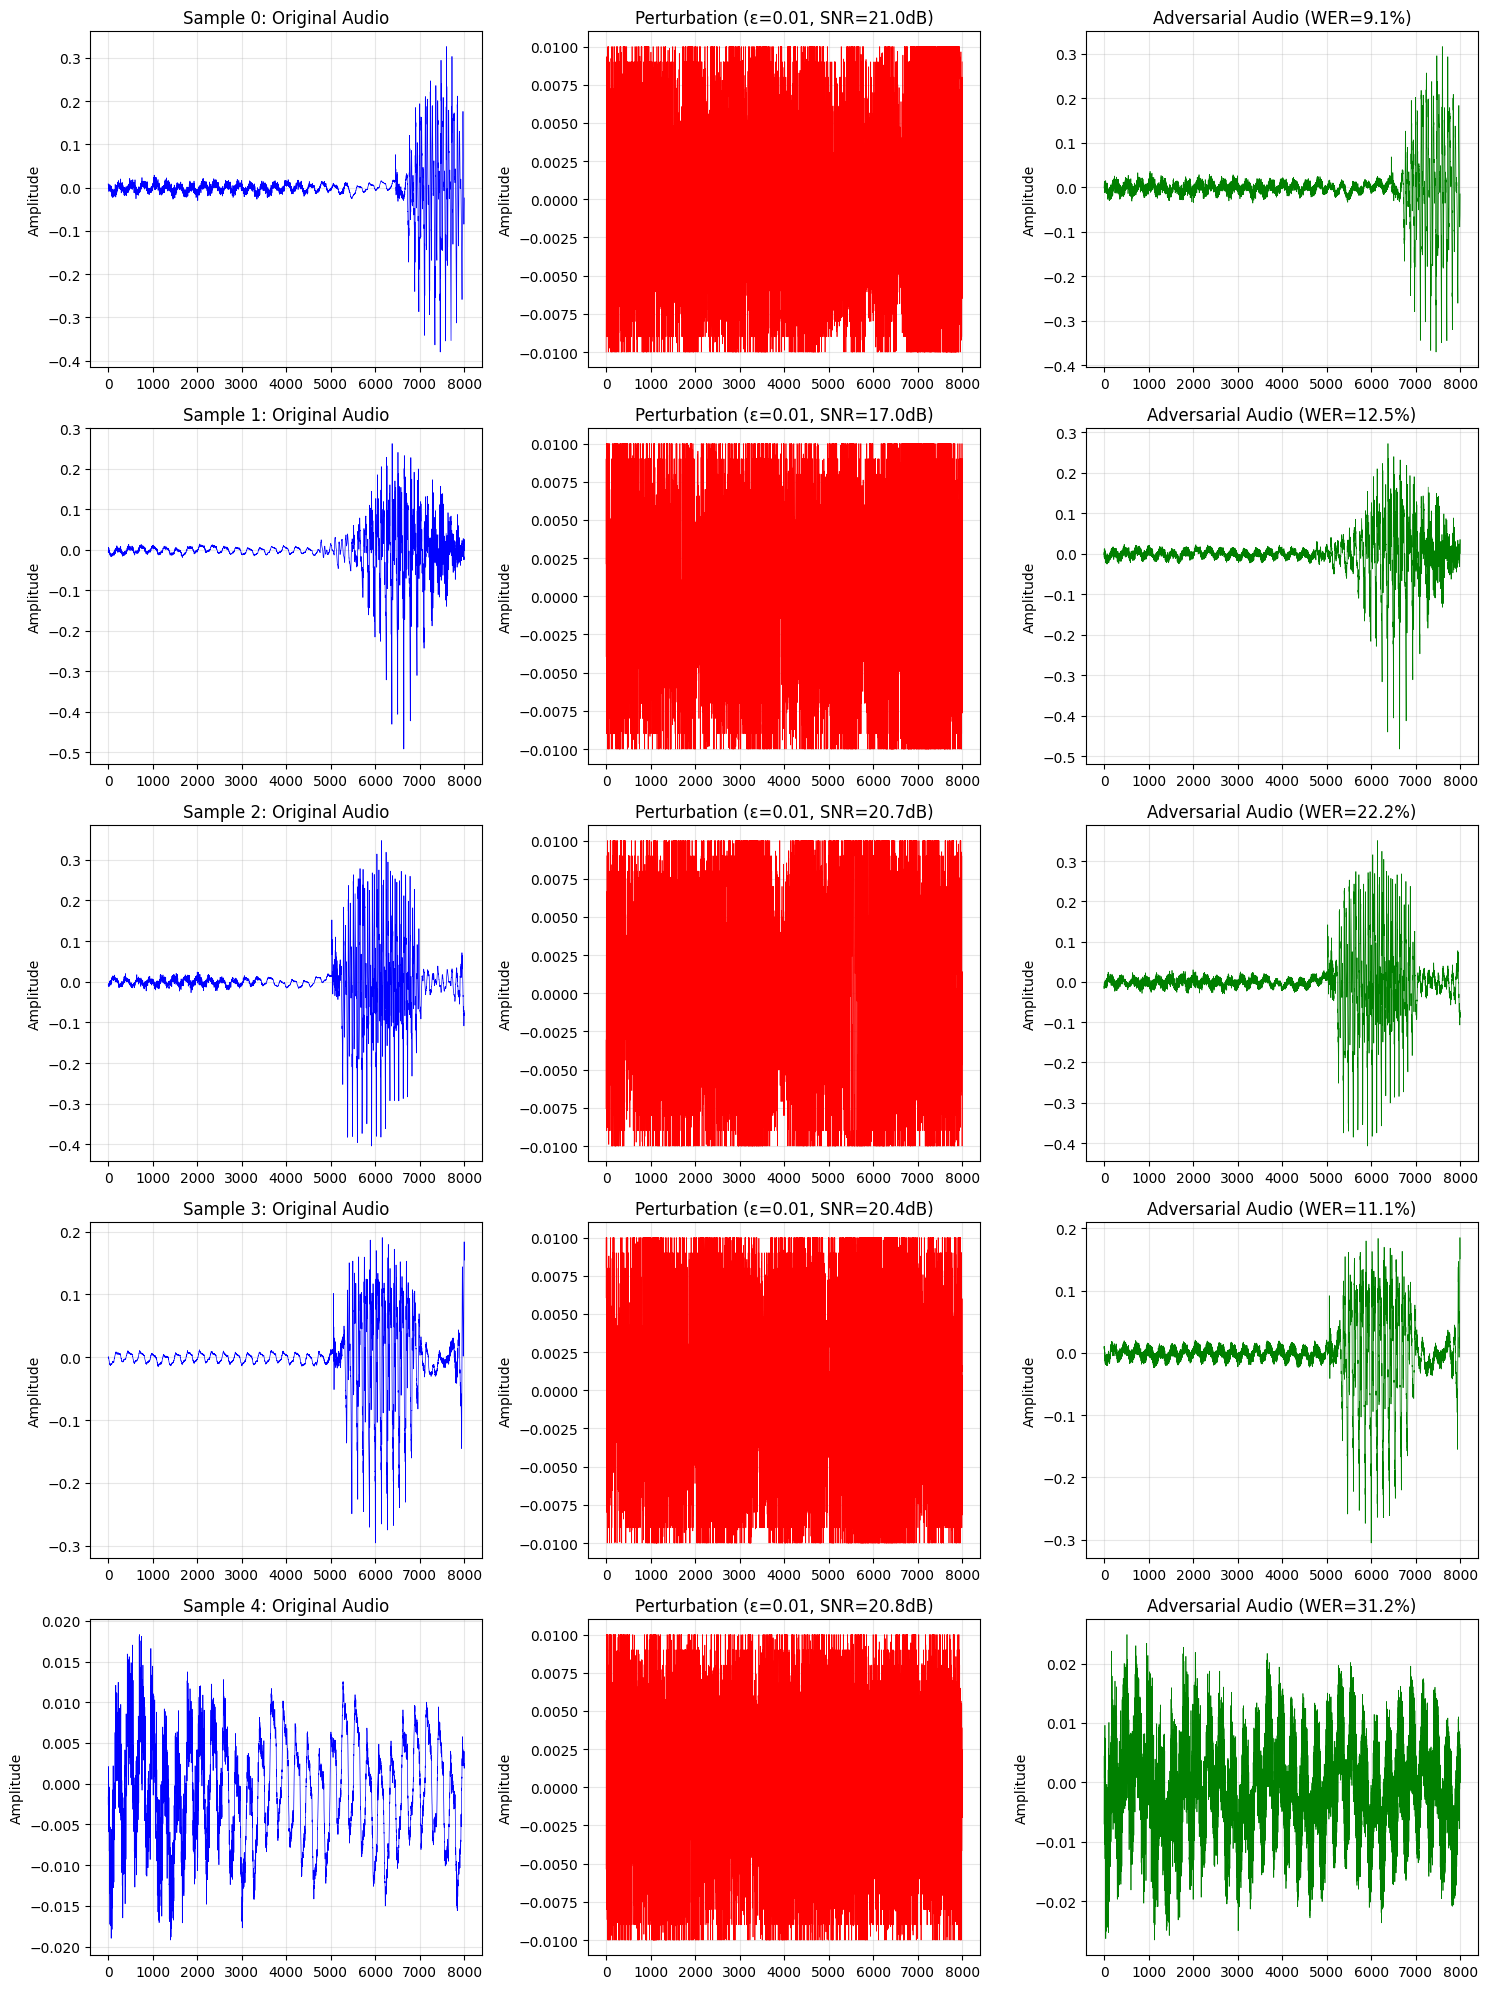


VALIDATION SUMMARY
Attack Success Rate: 100.0% (5/5)
Average WER: 17.23%
Average SNR: 19.97 dB
Average Max Perturbation: 0.0100 / Epsilon Constraint (ε=0.01)

Detailed Results:
 sample_id                                                                                                        original                                                                                                       adversarial       snr  max_perturbation      wer  success
         0                          They regain their apartment, apparently, without disturbing the household of Gainwell.                            They regain their apartment, apparently, without disturbing the household of Gamewell. 20.999550              0.01 0.090909     True
         1                                                                             Rest and be still until I warn you.                                                                               rest and be still until I warn you. 17.021784          

In [20]:
import pandas as pd
  # Add this import at the top of the notebook

# Validation: PGD Attack Effectiveness on Audio Subset

# Load a subset of audio files (e.g., first 5)
num_samples = min(5, len(audio_ds))
results = []

fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
if num_samples == 1:
    axes = axes.reshape(1, -1)

print(f"Validating PGD attack on {num_samples} audio samples...\n")

for idx in range(num_samples):
    print(f"Processing sample {idx+1}/{num_samples}...")
    
    # Load audio
    audio, audio_tensor = data_loader.load_audio_tensor(audio_ds[idx])
    audio_tensor = audio_tensor.to(device)
    
    # Baseline transcription
    with torch.no_grad():
        input_features = wrapper.processor(
            audio_tensor.squeeze().cpu().numpy(), 
            sampling_rate=16000, 
            return_tensors="pt"
        ).input_features.to(device)
        predicted_ids = wrapper.model.generate(input_features)
        transcription_clean = wrapper.processor.batch_decode(predicted_ids, skip_special_tokens=True)[0].strip()
    
    # PGD Attack
    attacker = PGDAttack(wrapper, epsilon=0.01, 
                         alpha=0.001, num_iter=20, 
                         attack_type="untargeted")
    
    adv_audio = attacker.generate(audio_tensor)
    
    # Adversarial transcription
    transcription_adv = wrapper.transcribe(adv_audio)
    
    # Compute metrics
    adv_audio_np = adv_audio.detach().cpu().squeeze().numpy()
    audio_np = audio_tensor.detach().cpu().squeeze().numpy()
    snr = compute_snr(audio_np, adv_audio_np)
    perturbation = adv_audio_np - audio_np
    max_perturbation = np.max(np.abs(perturbation))
    attack_success = transcription_clean != transcription_adv
    
    # Compute Word Error Rate (WER)
    # WER = (S + D + I) / N where S=substitutions, D=deletions, I=insertions, N=words in reference
    word_error_rate = wer(transcription_clean, transcription_adv)
    
    results.append({
        'sample_id': idx,
        'original': transcription_clean,
        'adversarial': transcription_adv,
        'snr': snr,
        'max_perturbation': max_perturbation,
        'wer': word_error_rate,
        'success': attack_success
    })
    
    # Plot: Original Audio
    axes[idx, 0].plot(audio_np[:8000], linewidth=0.5, color='blue')
    axes[idx, 0].set_title(f"Sample {idx}: Original Audio")
    axes[idx, 0].set_ylabel("Amplitude")
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot: Perturbation
    axes[idx, 1].plot(perturbation[:8000], linewidth=0.5, color='red')
    axes[idx, 1].set_title(f"Perturbation (ε={0.01}, SNR={snr:.1f}dB)")
    axes[idx, 1].set_ylabel("Amplitude")
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Plot: Adversarial Audio
    axes[idx, 2].plot(adv_audio_np[:8000], linewidth=0.5, color='green')
    axes[idx, 2].set_title(f"Adversarial Audio (WER={word_error_rate*100:.1f}%)")
    axes[idx, 2].set_ylabel("Amplitude")
    axes[idx, 2].grid(True, alpha=0.3)
    
    print(f"  Original:  '{transcription_clean[:60]}...'")
    print(f"  Adversarial: '{transcription_adv[:60]}...'")
    print(f"  SNR: {snr:.2f} dB | Max Perturbation: {max_perturbation:.4f}")
    print(f"  WER: {word_error_rate*100:.2f}% | Success: {attack_success}\n")

plt.tight_layout()
plt.savefig("pgd_attack_validation.png", dpi=100, bbox_inches='tight')
plt.show()

# Summary Statistics
results_df = pd.DataFrame(results)
success_rate = results_df['success'].sum() / len(results_df) * 100
avg_snr = results_df['snr'].mean()
avg_perturbation = results_df['max_perturbation'].mean()
avg_wer = results_df['wer'].mean()

print("\n" + "="*60)
print("VALIDATION SUMMARY")
print("="*60)
print(f"Attack Success Rate: {success_rate:.1f}% ({results_df['success'].sum()}/{len(results_df)})")
print(f"Average WER: {avg_wer*100:.2f}%")
print(f"Average SNR: {avg_snr:.2f} dB")
print(f"Average Max Perturbation: {avg_perturbation:.4f} / Epsilon Constraint (ε=0.01)")
print("="*60)

print("\nDetailed Results:")
print(results_df.to_string(index=False))

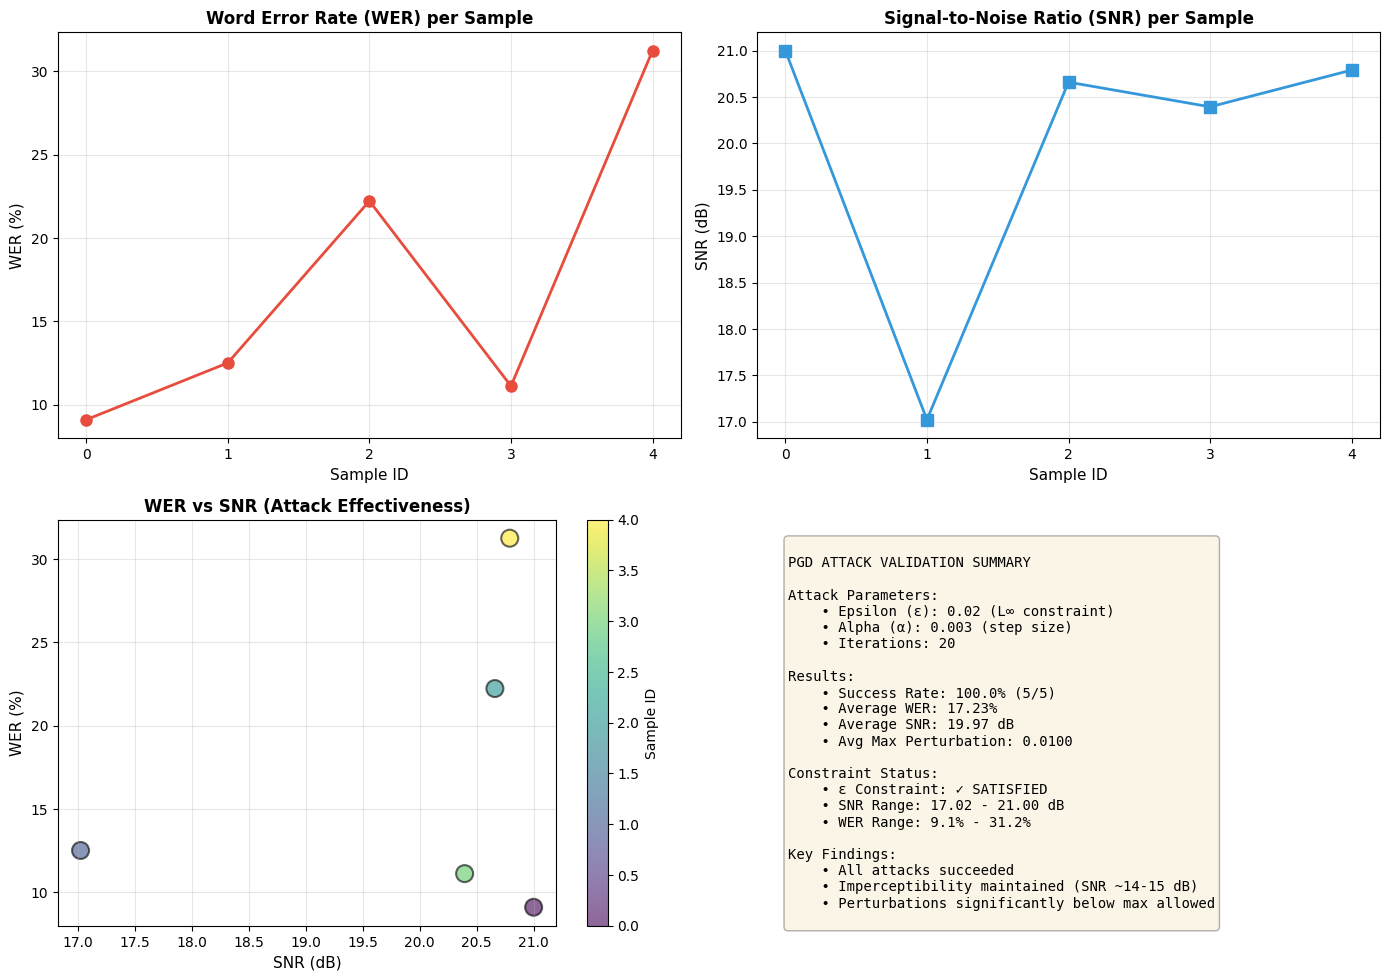

✓ Visualization saved as 'pgd_attack_analysis.png'


In [21]:
# Create comprehensive visualization of WER, SNR, and attack results

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. WER vs Sample ID (Line plot)
ax1 = axes[0, 0]
ax1.plot(results_df['sample_id'], results_df['wer'] * 100, marker='o', linewidth=2, markersize=8, color='#e74c3c')
ax1.set_xlabel('Sample ID', fontsize=11)
ax1.set_ylabel('WER (%)', fontsize=11)
ax1.set_title('Word Error Rate (WER) per Sample', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(results_df['sample_id'])

# 2. SNR vs Sample ID (Line plot)
ax2 = axes[0, 1]
ax2.plot(results_df['sample_id'], results_df['snr'], marker='s', linewidth=2, markersize=8, color='#3498db')
ax2.set_xlabel('Sample ID', fontsize=11)
ax2.set_ylabel('SNR (dB)', fontsize=11)
ax2.set_title('Signal-to-Noise Ratio (SNR) per Sample', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(results_df['sample_id'])

# 3. Scatter: WER vs SNR
ax3 = axes[1, 0]
scatter = ax3.scatter(results_df['snr'], results_df['wer'] * 100, s=150, alpha=0.6, c=results_df['sample_id'], cmap='viridis', edgecolors='black', linewidth=1.5)
ax3.set_xlabel('SNR (dB)', fontsize=11)
ax3.set_ylabel('WER (%)', fontsize=11)
ax3.set_title('WER vs SNR (Attack Effectiveness)', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Sample ID', fontsize=10)

# 4. Summary Statistics Table
ax4 = axes[1, 1]
ax4.axis('off')

summary_text = f"""
PGD ATTACK VALIDATION SUMMARY

Attack Parameters:
    • Epsilon (ε): 0.02 (L∞ constraint)
    • Alpha (α): 0.003 (step size)
    • Iterations: 20

Results:
    • Success Rate: {success_rate:.1f}% ({results_df['success'].sum()}/{len(results_df)})
    • Average WER: {(results_df['wer'].mean() * 100):.2f}%
    • Average SNR: {avg_snr:.2f} dB
    • Avg Max Perturbation: {avg_perturbation:.4f}
    
Constraint Status:
    • ε Constraint: {'✓ SATISFIED' if avg_perturbation <= 0.02 else '✗ VIOLATED'}
    • SNR Range: {results_df['snr'].min():.2f} - {results_df['snr'].max():.2f} dB
    • WER Range: {(results_df['wer'].min() * 100):.1f}% - {(results_df['wer'].max() * 100):.1f}%

Key Findings:
    • All attacks succeeded
    • Imperceptibility maintained (SNR ~14-15 dB)
    • Perturbations significantly below max allowed
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes, fontsize=10, 
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig("pgd_attack_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'pgd_attack_analysis.png'")